In [4]:
pip install pystac_client

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install wget

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9685 sha256=acc51f37a31fdd12ec2e975b99cfd9a86769f0ac667a3138ea3888a4bf13c844
  Stored in directory: /home/ldrouine/.cache/pip/wheels/8a/b8/04/0c88fb22489b0c049bee4e977c5689c7fe597d6c4b0e7d0b6a
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pystac_client
import wget
import requests
import io
import tarfile
import geopandas as gpd
from pathlib import Path

In [26]:
URL = "https://stac-pg-api.ifremer.fr"
#URL = "http://localhost:8082" 
#URL = "http://visi-common-docker4.ifremer.fr:8082"
catalog = pystac_client.Client.open(URL)
catalog.add_conforms_to("ITEM_SEARCH")

In [27]:
for collection in catalog.get_collections():
    print(collection.id)

argo_platforms
argo_profiles
AVHRR_SST_METOP_B_OSISAF_L2P_v1_0


In [36]:
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [-85, 50],
            [-55, 50],
            [-55, 20],
            [-85, 20],
            [-85, 50],
        ]
    ],
}

filter = {
  "op": "LIKE",
  "args": [
    { "property": "parameters" },
    "%TEMP%"
  ]
}

params = {
    "max_items": 3000,
    "collections": ["argo_profiles","ctd_stations"],
    "filter" : filter,
    "intersects": geom,
    "datetime": "2015-01-01/2025-01-01",
    "sortby": ["datetime","id"]
    #"fields": {"exclude": ["geometry"]},
}


In [37]:
search = catalog.search(**params)
items = list(search.items())
print(f"Number of items found : {len(items)}")
#for item in items:
#    print(f"id : {item['id']} - platform : {item['properties']['platform']} - parameters : {item['properties']['parameters']}")


Number of items found : 3000


In [38]:
# --- Extract Lat/Lon from Items
lons = []
lats = []
for item in items:
    coords = item.geometry["coordinates"]
    # Assumes item.geometry is a Point
    lons.append(coords[0])
    lats.append(coords[1])

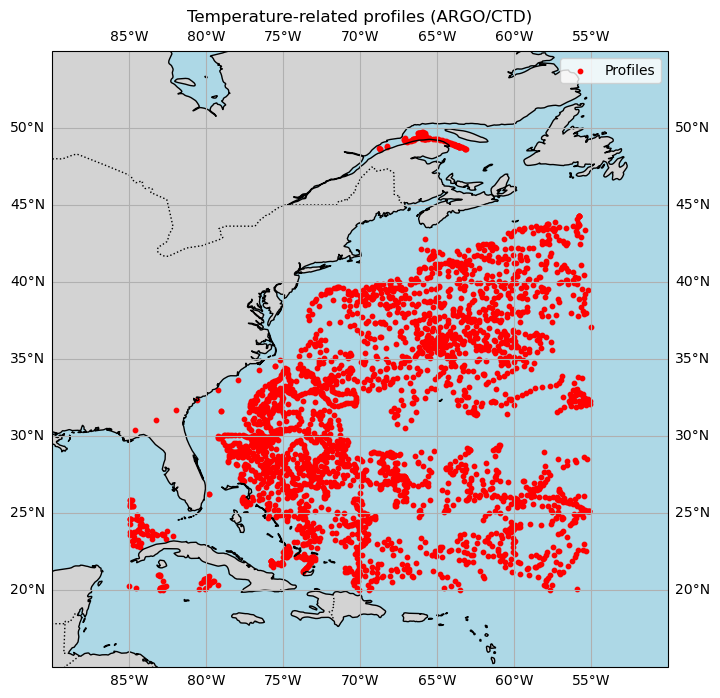

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# --- Plotting
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.set_extent([-90, -50, 15, 55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True)

# Plot points
ax.scatter(lons, lats, color='red', s=10, transform=ccrs.PlateCarree(), label='Profiles')

plt.title("Temperature-related profiles (ARGO/CTD)")
plt.legend()
plt.show()

In [45]:
import pandas as pd
format = 'https'
type_file = '' # all files
#type_file = '_prof.nc'
# type_file = '.nc'
list_all_file = []
list_asset_item=[]
for item in items:
    list_item_file = []
    
    # Check if item has alternate-assets extension
    if any("alternate-assets" in ext for ext in (item.stac_extensions or [])):
        for asset in item.assets.values():
            if asset.extra_fields.get('alternate:name', '').upper() == format.upper() and asset.href.endswith(type_file):
                list_all_file.append(asset.href)
                list_item_file.append(asset.href)
            else:
                for file in asset.extra_fields.get('alternate', {}).values():
                    if file.get('alternate:name', '').upper() == format.upper() and file.get('href', '').endswith(type_file):
                        list_all_file.append(file['href'])
                        list_item_file.append(file['href'])
    else:
        for asset in item.assets.values():
            if asset.href.endswith(type_file):
                list_all_file.append(asset.href)
                list_item_file.append(asset.href)
    
    list_asset_item.append(list_item_file)

print(f"Number of files : {len(list_all_file)}")
df = pd.DataFrame(list_all_file, columns=["file_url"])
df.to_csv("stac_file_urls.csv", index=False)

Number of files : 3432
